## SDF Library

In [29]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import optax
from timeit import default_timer as timer


In [30]:
def _length(a):
    return jnp.linalg.norm(a, axis=1)

ORIGIN = jnp.array((0, 0))

SEED = jax.random.PRNGKey(0)
def seed():
    global SEED
    SEED, _ = jax.random.split(SEED)

def circle(radius=1, center=(0, 0)):
    center = jnp.array(center)
    def f(p):
        return _length(p - center) - radius

    return f

def translate(sdf, offset):
    offset = jnp.array(offset)
    def f(p):
        return sdf(p - offset)

    return f


def rotate(sdf, angle):
    s = jnp.sin(angle)
    c = jnp.cos(angle)
    m = 1 - c
    matrix = jnp.array(
        [
            [c, -s],
            [s, c],
        ]
    ).T

    def f(p):
        return sdf(jnp.dot(p, matrix))

    return f

def rotate_around_center(sdf, angle, center):
    center = jnp.array(center)

    def f(p):
        v = translate(rotate(translate(sdf, -center), angle), center)(p)
        return v

    return f

def rectangle(size=1, center=(0, 0)):
    center = jnp.array(center)
    size = jnp.array(size)

    def f(p):
        q = jnp.abs(p - center) - size / 2
        return _length(jnp.maximum(q, 0)) + jnp.minimum(jnp.amax(q, axis=1), 0)

    return f

def bottom_half_plane(p):
    return p[:, 1]

def intersection(sdf1, sdf2):
    def f(p):
        return jnp.maximum(sdf1(p), sdf2(p))
    return f



In [31]:
def show_sdf(sdf, bounds=(-1, 1), n=500):
    x = jnp.linspace(bounds[0], bounds[1], n)
    X, Y = jnp.meshgrid(x, x)

    grid_points = jnp.column_stack((X.flatten(), Y.flatten()))
    plt.imshow(1-inside(sdf)(grid_points).reshape(n, n), cmap="gray", origin="lower", extent=[bounds[0], bounds[1],bounds[0], bounds[1]])

In [32]:
N = 100000
shape = (N, 2)
dtype = jnp.float64

def naive_area(sdf, bounds=[-1, 1], n=1000):
    points = jax.random.uniform(SEED, (n, 2), jnp.float32, bounds[0], bounds[1])
    computed_sdf = sdf(random_numbers) < 0
    return jnp.sum(computed_sdf) / n * (bounds[1] - bounds[0])**2

In [33]:
def inside(sdf):
   def f(p):
       distance = sdf(p)
       return 1-jax.nn.sigmoid(100* distance)

   return f

In [34]:
def area(sdf, points, bounds=[-1, 1]):
    computed_sdf = inside(sdf)(points)
    return jnp.average(computed_sdf, axis=0) * (bounds[1] - bounds[0])**2


In [35]:
def centroid(sdf, points, bounds=[-1, 1]):
    inside_points = inside(sdf)(points)
    return jnp.average(points, weights=inside_points, axis=0)

## The boat problem

In [36]:
RELATIVE_DENSITY = 0.5
SAMPLE_SIZE = 10000
INTEGRATION_BOUNDS = (-3, 3)

In [46]:
def update_position(original_shape, original_shape_center, p1, p2):
    return translate(rotate_around_center(original_shape, jnp.atan(p1), original_shape_center), (0, p2))

def alignment_cost(shape, points):
    shape_center_of_gravity = centroid(shape, points, bounds=INTEGRATION_BOUNDS)
    shape_area = area(shape, points, bounds=INTEGRATION_BOUNDS)

    shape_weight = shape_area * RELATIVE_DENSITY

    displacement = intersection(bottom_half_plane, shape)
    buoyancy_center = centroid(displacement, points, bounds=INTEGRATION_BOUNDS)

    displacement_weight = area(displacement, points, bounds=INTEGRATION_BOUNDS)

    gravity_cost = displacement_weight - shape_weight
    torque_cost = (buoyancy_center - shape_center_of_gravity)[0]

    costs = jnp.array([gravity_cost, torque_cost])
    return jnp.dot(costs, costs)

#### Helper functions

In [38]:
def center_of_gravity(shape, points):
    return centroid(shape, points, bounds=INTEGRATION_BOUNDS)

def center_of_buoyancy(shape, points):
    displacement = intersection(bottom_half_plane, shape)
    return centroid(displacement, points, bounds=INTEGRATION_BOUNDS)


In [53]:
solver = optax.rmsprop(learning_rate=0.003)

In [63]:
def find_equilibrium(shape, reset_seed=False, sample_size = 10000, iterations=500):
    seed = SEED
    points = jax.random.uniform(seed, (sample_size, 2), jnp.float32, INTEGRATION_BOUNDS[0], INTEGRATION_BOUNDS[1])
    shape_cof = center_of_gravity(shape, points)

    @jax.jit
    def cost(x, pts):
        cost = alignment_cost(update_position(shape, shape_cof, x[0], x[1]), pts)
        return cost

    cost_grad = jax.grad(cost)
    params = (0.,0.)
    opt_state = solver.init(params)
    for i in range(iterations):
        if reset_seed:
            seed, rng = jax.random.split(seed)
            points = jax.random.uniform(rng, (sample_size, 2), jnp.float32, INTEGRATION_BOUNDS[0], INTEGRATION_BOUNDS[1])
        grad = cost_grad(params, points)
        updates, opt_state = solver.update(grad, opt_state, params)
        params = optax.apply_updates(params, updates)
        err = cost(params, points)
        if (i % 100 == 0):
            print('Cost: {:.2E}'.format(err))

    print("translation", params[0])
    print("rotation", jnp.atan(params[1]))

    end_shape = update_position(shape, shape_cof, params[0], params[1])

    show_sdf(end_shape, bounds=(-3, 3))

    plt.scatter(*center_of_gravity(end_shape, points), c="red")
    plt.scatter(*center_of_buoyancy(end_shape, points), c="blue")

In [67]:
def grad_at_origin(shape):
    points = jax.random.uniform(SEED, (10000, 2), jnp.float32, INTEGRATION_BOUNDS[0], INTEGRATION_BOUNDS[1])
    shape_cof = center_of_gravity(shape, points)

    def cost(x, y):
        return alignment_cost(update_position(shape, shape_cof, x, y), points)
    return jax.value_and_grad(cost, (0, 1))(jnp.array(0.0), jnp.array(0.0))


### Solving the equilibrium of a rectangle

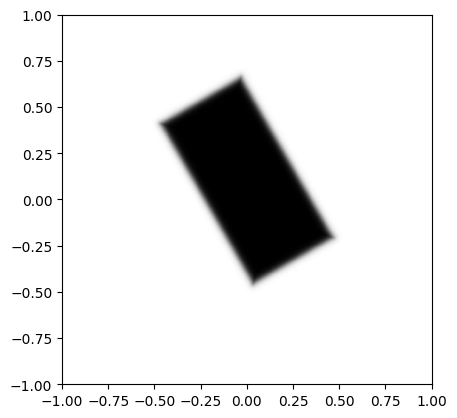

In [42]:
rectangle_sdf = translate(rotate(rectangle((1,0.5)), jnp.pi / 3), (0, 0.1))
show_sdf(rectangle_sdf)

In [70]:
grad_at_origin(rectangle_sdf)

(Array(0.0205248, dtype=float32),
 (Array(nan, dtype=float32, weak_type=True),
  Array(nan, dtype=float32, weak_type=True)))

We have a problem here - the grad at the origin is nan. I guess this comes from the amin function used in the (copied from sdfCAD) definition of the rectangle. We should probably look into improving this.

In order to figure out what is going on - let's try something easier - a circle.

### Solving the equilibrium of a circle

In [68]:
grad_at_origin(circle(1, (0, -0.5)))

(Array(1.025972, dtype=float32),
 (Array(0.00614443, dtype=float32, weak_type=True),
  Array(-3.744237, dtype=float32, weak_type=True)))

Cost: 1.28E+00
Cost: 4.14E-02
Cost: 5.29E-02
Cost: 8.38E-03
Cost: 4.33E-02
translation -0.44116655
rotation 0.4230419


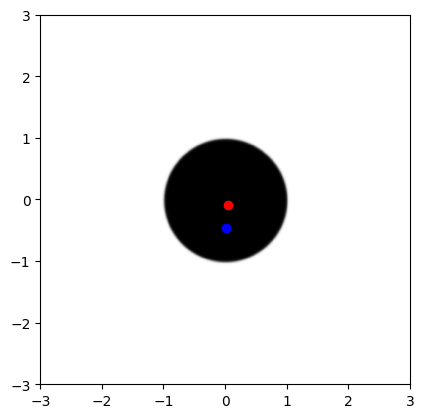

In [59]:
find_equilibrium(circle(1, (0, -0.5)), True, 1000, 1000)

Yeah, it work - but this is only concerned with gravity. Let's try something a bit less symmetrical.

### Solving the equilibrium of a partial circle

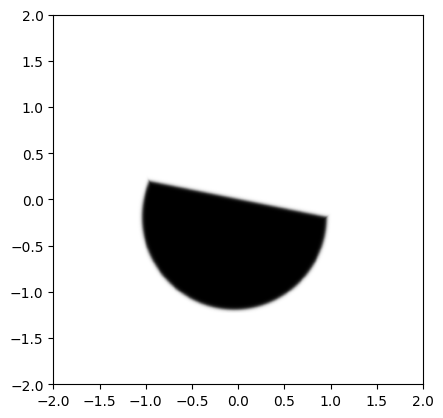

In [48]:
partial_circle = rotate(intersection(translate(circle(), (0, -0.2)), bottom_half_plane), 0.2)

show_sdf(partial_circle, bounds=[-2, 2])

In [69]:
grad_at_origin(partial_circle)

(Array(0.7874661, dtype=float32),
 (Array(-1.0949372, dtype=float32, weak_type=True),
  Array(-1.9089831, dtype=float32, weak_type=True)))

Cost: 1.16E+00
Cost: 1.91E-01
Cost: 8.47E-02
Cost: 4.29E-03
Cost: 6.43E-03
translation -0.13167576
rotation 0.4328083


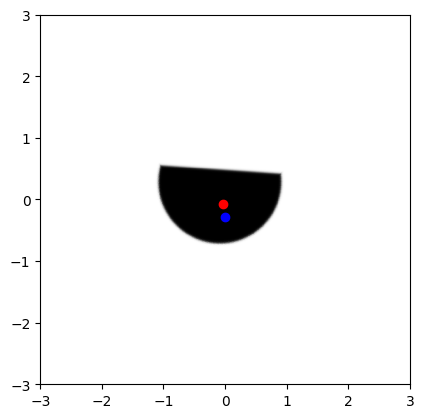

In [66]:
find_equilibrium(partial_circle, True, 1000, 500)